# Simple Bitcoin predictive Model

## Imports & API

### Imports

In [1]:
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import requests 
import matplotlib as plt
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('keys.json') as f:
    key = json.loads(f.read())

### API Fetching & Cleaning Crypto

Variables of note: <br>
```c_code``` = Crypto value's code <br>
```c_market``` = Crypto value's market <br>
```c_``` = Cryto value's common name <br>
```crypto.columns = ['open','high','low','close','volume','cap']```

In [3]:
#declaring Fetch parameters
c_code = 'BTC'
c_market = 'USD'

In [4]:
#Fetching Data
cryptos = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}".format(c_code,c_market,key['api_key']))

In [5]:
#Assigning "name" for ease
c_ = cryptos.json()['Meta Data']['3. Digital Currency Name']

In [6]:
#Organizing Data
crypto = pd.DataFrame.from_dict(cryptos.json()['Time Series (Digital Currency Daily)'],orient='index',dtype='float')
crypto = crypto.drop(['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
crypto.columns = ['open','high','low','close','volume','cap']
crypto.index = pd.to_datetime(crypto.index)

In [7]:
#Cleaning Missing Data
print("There are {} days between the first and last time stamp, however our API captured {} days.".format(str(crypto.index[-1] - crypto.index[0]).split(" ")[0],len(crypto)))

There are 1457 days between the first and last time stamp, however our API captured 1458 days.


In [8]:
if int(str(crypto.index[-1] - crypto.index[0]).split(" ")[0]) - len(crypto) > 5:
    idx = pd.date_range(crypto.index[0], crypto.index[-1])
    crypto = crypto.reindex(idx, fill_value=np.nan)
    print("So we will need to interpolate the {} missing days.".format(crypto.isnull().sum()[0]))
    crypto = crypto.interpolate()
else:
    print("as such we dont need to interpolate any missing days")

as such we dont need to interpolate any missing days


In [9]:
crypto.to_csv('./bit.csv')

In [10]:
#will import last fetched csv
#crypto = pd.read_csv('./bit.csv',index_col=0)

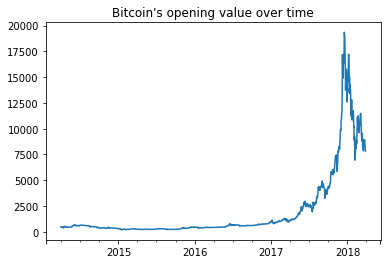

In [11]:
#Sanity Check
crypto.open.plot();
plt.title("{}'s opening value over time".format(c_));

In [12]:
reddit = pd.read_csv('./Reddit_Crypto.csv')

In [13]:
reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date']).dt.date

In [14]:
#I am only doing the number of comments per day in the cryt subreddit
reddit = pd.DataFrame(reddit.groupby('date')['comments'].sum())

In [15]:
reddit.index = pd.to_datetime(reddit.index)

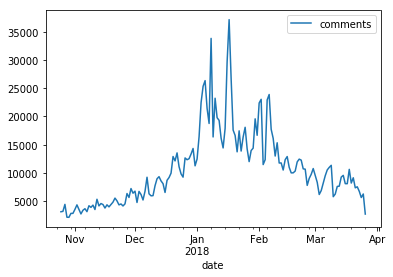

In [16]:
reddit.plot();

In [17]:
#I will eventually implment a predictor comparing reddit comments with the values
#bit = bit.join(reddit)

## Preliminary EDA

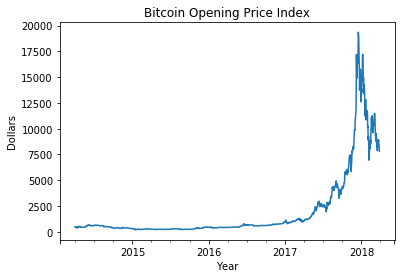

In [18]:
#
crypto.open.plot()
plt.title('{} Opening Price Index'.format(c_))
plt.ylabel('Dollars')
plt.xlabel('Year');

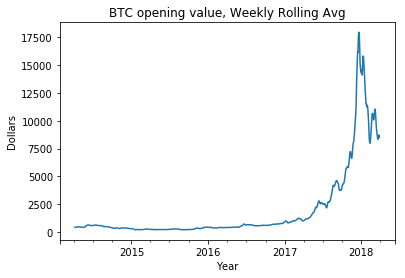

In [19]:
#weekly rolling avg by week
crypto.open.rolling(window=7, center=False).mean().plot()
plt.title('{} opening value, Weekly Rolling Avg'.format(c_code))
plt.ylabel('Dollars')
plt.xlabel('Year');

### Autocorrelation & Partial Autocorrelation

because of how correlated every day's bitcoin value is dependant on the day before,
we look at its autocorrelation.
    - (correlation, to itself)

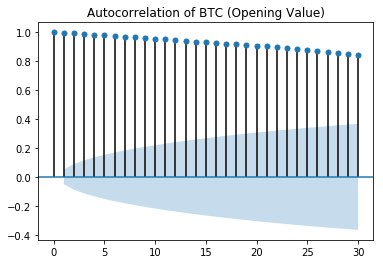

In [20]:
plot_acf(crypto.open, lags=30)
plt.title('Autocorrelation of {} (Opening Value)'.format(c_code));

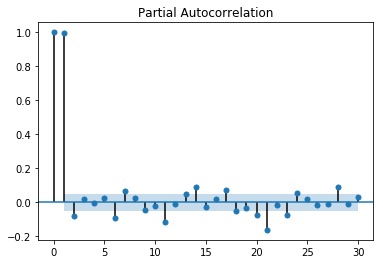

In [21]:
plot_pacf(crypto.open, lags=30);

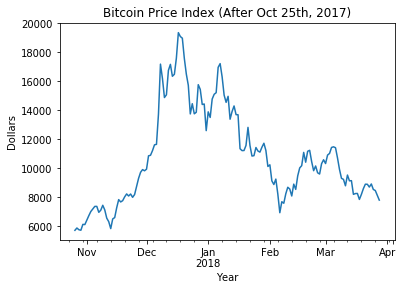

In [22]:
#
crypto[crypto.index>'2017-10-25']['open'].plot()
plt.title('{} Price Index (After Oct 25th, 2017)'.format(c_))
plt.ylabel('Dollars')
plt.xlabel('Year');

In [23]:
"""
bit[bit.index>'2017-10-25']['comments'].plot()
plt.title('BitCoin Reddit Activity (After Oct 25th, 2017)')
plt.ylabel('n Comments')
plt.xlabel('Year');
"""

"\nbit[bit.index>'2017-10-25']['comments'].plot()\nplt.title('BitCoin Reddit Activity (After Oct 25th, 2017)')\nplt.ylabel('n Comments')\nplt.xlabel('Year');\n"

## Trend, Seasonality & Trend

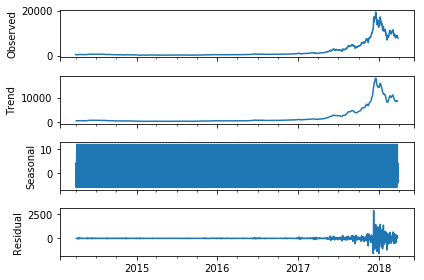

In [24]:
result = seasonal_decompose(crypto.open)
result.plot();

Well that looks like a mess, likely due to the amount of time when bitcoin was worthless

Lets look at it when bitcoin became a bit more relivant

In [25]:
relivant  = crypto[crypto.open.index>'2016-10-27']['open']

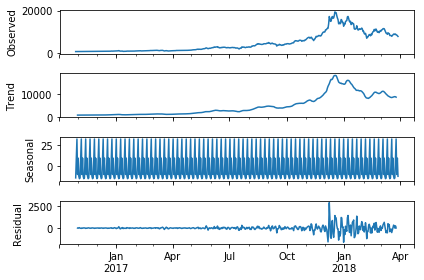

In [26]:
result = seasonal_decompose(relivant)
result.plot();

That looks better, but still a lot of dead time

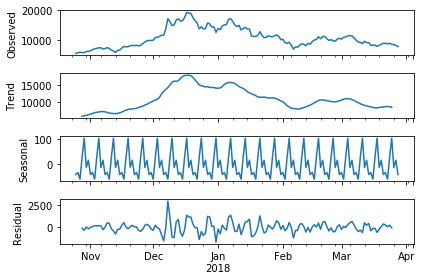

In [27]:
more_rel = crypto[crypto.index>='2017-10-25']
seasonal_decompose(more_rel.open).plot();

Much better, well now we can see some clearer trends.

This shows us:
    - a clearer trend over time peaking in late Dec
    - Bitcoin does not seem to be heavily affected by seasonality, only +/- 100
    - Residuals seem to make up the majority of variability, which makes sense consider how  bitcoins have stronger social driving factors rather than seasonal/global

Looking for other predictors of Bitcoin Value:
    - I am curious to see if reddit's cryptocurrency subreddit may be a predictor.

In [28]:
#bit = bit[bit.index>='2017-10-25']

In [29]:
#seasonal_decompose(bit.comments).plot();

It looks like the comments are much more affected by seasonality, than the coin's value, however +/- 2000 is still not very much when compared to the noise of 10,000

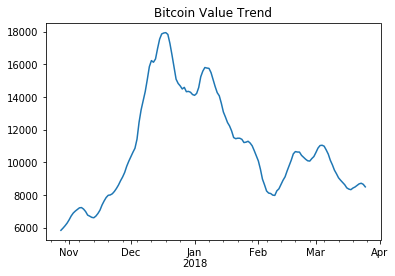

In [30]:
seasonal_decompose(more_rel.open).trend.plot()
plt.title('{} Value Trend'.format(c_));

In [31]:
#seasonal_decompose(bit.comments).trend.plot()
#plt.title('Reddit Activity Trend');

In [32]:
"""
plt.subplot(211)
seasonal_decompose(more_rel).trend.plot()
plt.title('Bitcoin Value Trend')
plt.subplot(212)
seasonal_decompose(bit.comments).trend.plot()
plt.title('Reddit Activity Trend');
"""

"\nplt.subplot(211)\nseasonal_decompose(more_rel).trend.plot()\nplt.title('Bitcoin Value Trend')\nplt.subplot(212)\nseasonal_decompose(bit.comments).trend.plot()\nplt.title('Reddit Activity Trend');\n"

## LSTM RNN

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

First our data needs to be scaled before being split
    - Otherwise the values at time n would be not properly scaled to the min and max of the data at time n-

In [62]:
train = crypto.open[crypto.index<'2018-03-01']
test = crypto.open[crypto.index>='2018-03-01']

In [38]:
#train = more_rel.open[more_rel.index<'2018-02-01']
#test = more_rel.open[more_rel.index>='2018-02-01']

In [63]:
#NN need values between 0-1
mm = MinMaxScaler()

#preprocessing
#mm scaler needs atleast a 2D array
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

#here we are predicting Q days ahead
Q = 7
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

#RNN again, needs reshaping
#the shaping choices were picked for if I want to use a multi-dim training
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [69]:
def model(X_train, y_train, dropout= 0.1, batch_size = 16, lstm_units = 7, activation = 'relu'):
    # Initialising the RNN
    regressor = Sequential()
    
    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units = lstm_units, activation = activation, input_shape = (None, 1)))
    regressor.add(Dropout(dropout))
    
    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mae')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = batch_size, epochs = 10,verbose=0)
    return(regressor)

In [70]:
regressor = model(X_train,y_train)

In [59]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

#reshaped for NN
val = np.reshape(val, (len(val), 1, 1))
predicted_BTC_price = regressor.predict(val)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

In [60]:
pred = pd.DataFrame({'True':test_set,'Pred':predicted_BTC_price},index=test.index)

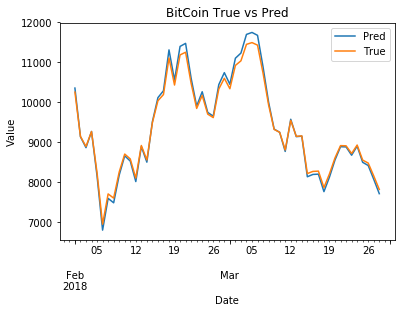

In [61]:
pred.plot()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

- This likely tells us that for the most part the NN assumes the value of bitcoin will remain more stable than it usually does (considering bitcoin's volitile nature)
- This can be remedied by:
    - Increasing the # of feature by which it is calculating the values
    - Adjust the memory that the NN fetchs from in the LSTM cells
    - Train more
        - the fear with that comes from overfitting to pre-existing trends which would ultimately do no more than say 'the score is basically yesterday's score'

## ARIMA

Lets go back to more traditional forcasting models

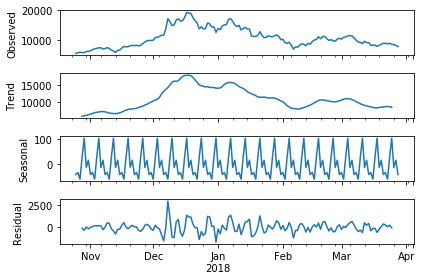

In [72]:
season = seasonal_decompose(more_rel.open)
season.plot();

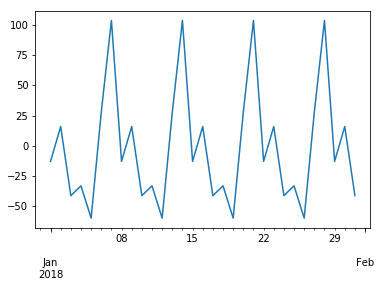

In [91]:
#It looks like the variation may align with weeks
season.seasonal[68:99].plot();

In [138]:
first_m = pd.DataFrame({"season":season.seasonal})

In [139]:
first_m['day'] = first_m.index.weekday_name

In [143]:
first_m.groupby('day')['season'].mean()

day
Friday       -59.923583
Monday       -12.924645
Saturday      27.776060
Sunday       103.714346
Thursday     -33.208645
Tuesday       15.888548
Wednesday    -41.322082
Name: season, dtype: float64

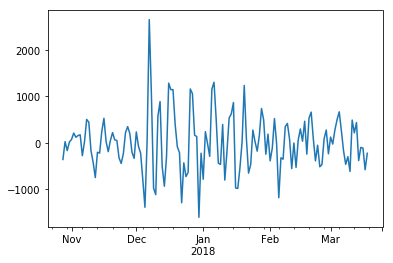

In [102]:
#Again huge imact
#It would be interesting to scrape the news/twitter/reddit 
#for what may have been a predictor for any underlying trends in these residuals
season.resid.plot();

In [144]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

### Seasonal Difference

In [153]:
S_ana = more_rel

In [149]:
#so reminder this is our data
more_rel.open.head()

2017-10-25    5520.211384
2017-10-26    5734.037478
2017-10-27    5893.778668
2017-10-28    5773.727637
2017-10-29    5739.640727
Name: open, dtype: float64

In [105]:
#remember we are paying attention to when bitcoin was relivant, 'more_rel' is a numpy array
#more_rel = bit[bit.index>='2017-10-25']

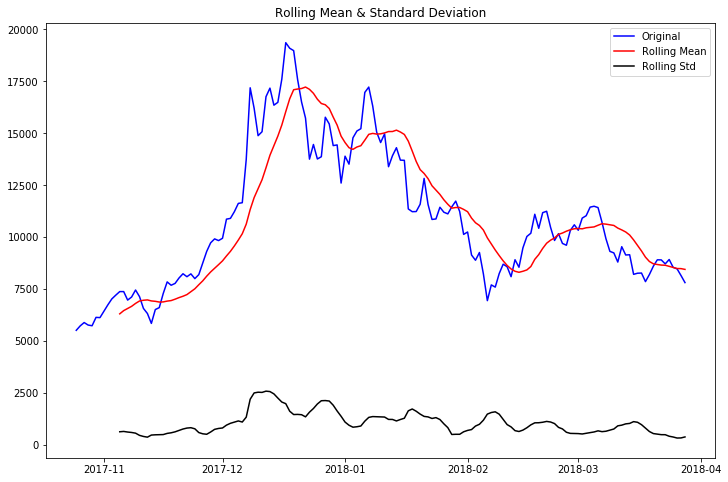

Results of Dickey-Fuller Test:
Test Statistic   -1.729727
p-value           0.415865
dtype: float64


In [154]:
#let us check and see how stationary the data is, so we can gather what we can from it
test_stationarity(S_ana.open)

Unsurprising, the values alone are NOT stationary, because it hasn't be adjusted for

Let us look at the differences by the day

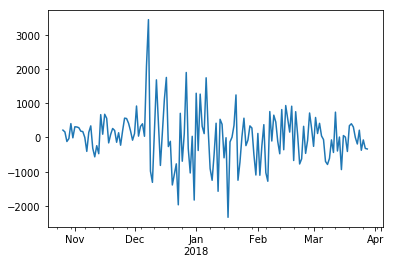

In [155]:
S_ana.open.diff(1).plot();

Let us check how stationary the data is

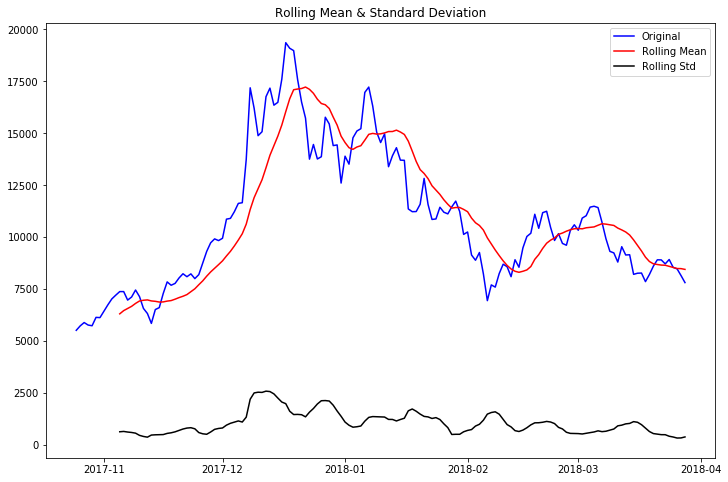

Results of Dickey-Fuller Test:
Test Statistic   -1.729727
p-value           0.415865
dtype: float64


In [156]:
test_stationarity(S_ana.open)

Well those map VERY heavily, because its the constant difference to the last value, so yeah it appears that the differences are stationary but that doesnt mean too much

Does finding the difference by the season AS well as the day improve things?

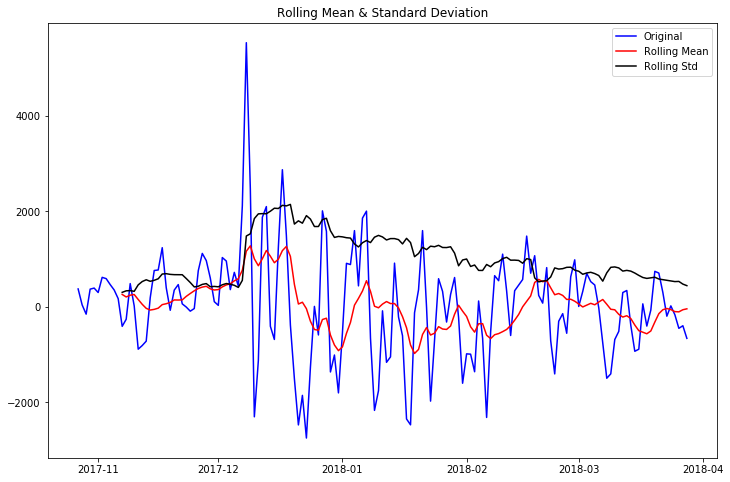

Results of Dickey-Fuller Test:
Test Statistic   -3.321645
p-value           0.013938
dtype: float64


In [184]:
#.diff(1) = diff by the day
#.diff(12) = diff by the months in year

test_stationarity(S_ana.open.diff(2).dropna())

Not dramatically

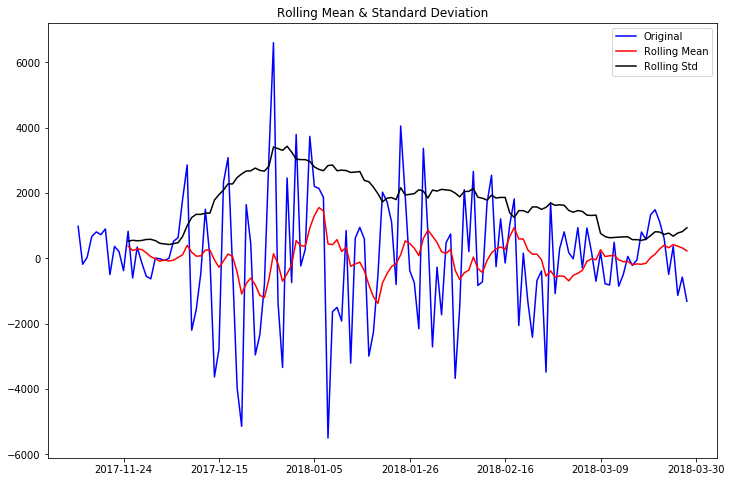

Results of Dickey-Fuller Test:
Test Statistic   -7.418797e+00
p-value           6.822658e-11
dtype: float64


In [158]:
#by day   - diff(1)
#by week  - diff(7)

test_stationarity(S_ana.open.diff(1).diff(7).diff(12).dropna())

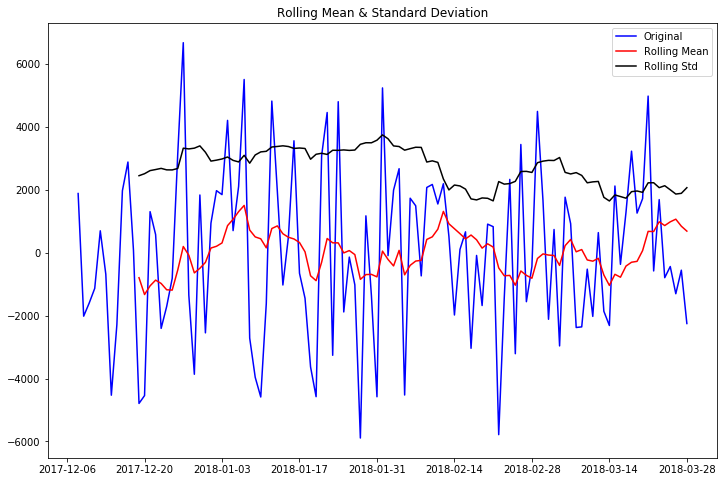

Results of Dickey-Fuller Test:
Test Statistic   -5.193746
p-value           0.000009
dtype: float64


In [159]:
#by day   - diff(1)
#by week  - diff(7)
#by month - diff(12)
#by hour  - diff(24)

#there are no more real valid ways to seperate, 
#this is not particularly useful because the values are so decomposed. 
#so this is purly for experimental purposes

test_stationarity(S_ana.open.diff(1).diff(24).diff(7).diff(12).dropna())

In [178]:
rr = S_ana.open.diff(2).dropna()

In [179]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

train_2 =  rr.head(len(rr)-21)
test_2 = rr.tail(21)

model = ARMA(train_2, (2,1)).fit()
model.summary()

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   open   No. Observations:                  132
Model:                     ARMA(2, 1)   Log Likelihood               -1071.655
Method:                       css-mle   S.D. of innovations            796.291
Date:                Fri, 30 Mar 2018   AIC                           2153.310
Time:                        19:01:32   BIC                           2167.724
Sample:                    10-27-2017   HQIC                          2159.167
                         - 03-07-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.0267    140.922      0.561      0.576    -197.175     355.228
ar.L1.open     0.0895      0.087      1.028      0.306      -0.081       0.260
ar.L2.open    -0.0699      0.087     -0.806      0.422      -0.240       0.100
ma.L1.open     1.0000      0.021     46.634      0.000       0.958       1.042
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6406           -3.7287j            3.7833           -0.2229
AR.2            0.6406           +3.7287j            3.7833            0.2229
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

- Wow that model did not do well

- Lets see if we can find something better with a gridsearch
    - there will be a lot of impossible combinations, hense the 'try' params

In [185]:
arima_parameters = {"d":[0,1,2,3,4,5,6,7],
                    "p":[0,1,2,3,4,5,6,7],
                    "q":[0,1,2,3,4,5,6,7]}

In [186]:
from tqdm import tqdm

In [187]:
aic_0 = {}
for d in tqdm(arima_parameters['d']):
    for p in tqdm(arima_parameters['p']):
        for q in arima_parameters['q']:
            try:
                AR2MA = ARIMA(train_2, (p,d,q)).fit();
                params = str('|d:{}|p:{}|q:{}|'.format(d,p,q));
                aic_0[params] = AR2MA.aic;
            except:
                continue

  0%|          | 0/8 [00:00<?, ?it/s]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):

 12%|█▎        | 1/8 [00:00<00:01,  4.77it/s]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodel

In [188]:
aic_0

{'|d:0|p:0|q:0|': 2246.430219432665,
 '|d:0|p:0|q:1|': 2150.8592105858784,
 '|d:0|p:1|q:0|': 2209.2143932577487,
 '|d:0|p:2|q:0|': 2190.763279609791,
 '|d:0|p:2|q:1|': 2153.3098662423577,
 '|d:0|p:2|q:2|': 2153.526711226143,
 '|d:0|p:3|q:0|': 2185.6587032217058,
 '|d:0|p:3|q:1|': 2155.308129722514,
 '|d:0|p:4|q:0|': 2185.865381150773,
 '|d:0|p:4|q:1|': 2156.730413325337,
 '|d:0|p:5|q:0|': 2184.6496153323073,
 '|d:0|p:5|q:1|': 2155.1453809526784,
 '|d:0|p:6|q:0|': 2177.2077720663583,
 '|d:0|p:6|q:1|': 2154.8629452201317,
 '|d:0|p:6|q:2|': 2156.836246922837,
 '|d:0|p:7|q:0|': 2171.939475899854,
 '|d:0|p:7|q:1|': 2156.8123311592008,
 '|d:0|p:7|q:3|': nan,
 '|d:1|p:0|q:0|': 2227.8660763948324,
 '|d:1|p:0|q:1|': 2213.6596145715093,
 '|d:1|p:0|q:2|': 2139.923988929382,
 '|d:1|p:0|q:3|': 2140.878781589065,
 '|d:1|p:1|q:0|': 2229.620220295222,
 '|d:1|p:1|q:1|': 2190.40623862043,
 '|d:1|p:1|q:2|': 2141.0194938372747,
 '|d:1|p:1|q:3|': 2140.5939130828656,
 '|d:1|p:1|q:4|': 2142.5747958472753,
 '

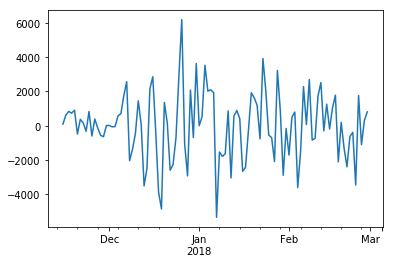

In [155]:
train_2.plot()

In [277]:
import seaborn as sns

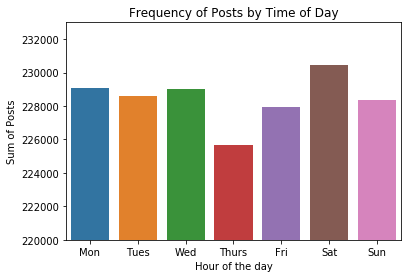

In [290]:
ax = sns.barplot(x=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
            y=rel.bpi.groupby(rel.index.dayofweek).sum())
ax.set_title('Frequency of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');
plt.ylim(220000, 233000);